<a href="https://colab.research.google.com/github/jonas-jun/DL_scratch2_study/blob/master/BERT_finetune_seqclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BERT finetuning on CoLA dataset for text classification

based on [explanation](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) by Chris McCormick

In [1]:
import torch
device = torch.device('cuda')

In [2]:
!pip install transformers

## Load Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
GDRIVE_HOME = '/content/drive/MyDrive'
FOLDER = 'GSDS/2021_1/cola_public'

Mounted at /content/drive


In [4]:
import pandas as pd
import os
df = pd.read_csv(os.path.join(GDRIVE_HOME, FOLDER, 'raw/in_domain_train.tsv'), delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [5]:
print(df.shape)
df.sample(5)

(8551, 4)


,sentence_source,label,label_notes,sentence
7124,sgww85,0,*,We talked about that our perspectives had chan...
5855,c_13,1,NaN,The swing blasted the golf ball across the green.
4706,ks08,1,NaN,We got our car radio stolen twice on holiday.
5366,b_73,1,NaN,Sally eats caviar more than I had expected.
5908,c_13,1,NaN,It bit me on the leg.


In [6]:
df['label'].value_counts()

1    6023
0    2528
Name: label, dtype: int64

**label**  
0: unacceptable  
1: acceptable

In [7]:
sentences = df['sentence'].values
labels = df['label'].values # '.values' series to array

## Tokenize dataset
1. 문장 앞 \<cls\> token, 문장 뒤 \<sep\> token을 붙인다.
2. Vocab을 참고하여 token을 ID로 바꾼다.
3. Max_length에 맞춰 padding
4. Attention mask (pad값들은 attention에서 반응하지 않도록)

In [8]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True, )

In [9]:
print('original: ', sentences[999])
print('tokenized: ', tokenizer.tokenize(sentences[999]))
print('token ID: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[999])))

original:  Rich we have impeccable taste.
tokenized:  ['rich', 'we', 'have', 'imp', '##ec', '##cable', 'taste', '.']
token ID:  [4138, 2057, 2031, 17727, 8586, 21170, 5510, 1012]


In [10]:
# get max length of dataset
max_len = 0

for sent in sentences:
    ids = tokenizer.encode(sent, add_special_tokens=True) # add <cls>, <sep>
    max_len = max(max_len, len(ids))

print(max_len)

47


In [11]:
input_ids = list()
attention_masks = list()

for sent in sentences:
    encoded = tokenizer.encode_plus(
        text=sent,
        add_special_tokens=True,
        max_length=64, # max_length of dataset: 47
        padding='max_length',
        return_attention_mask=True)
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask']) # 1: word, 0: pad token


In [12]:
print(encoded.keys()) # what returned
print(len(input_ids))
print(len(input_ids[999])) # length of one sample
print(input_ids[999])

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
8551
64
[101, 4138, 2057, 2031, 17727, 8586, 21170, 5510, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [13]:
input = torch.tensor(input_ids)
mask = torch.tensor(attention_masks)
labels = torch.tensor(labels)

print('sentence: {}'.format(sentences[0]))
print('ids: {}'.format(input[0]))
print('label: {}'.format(labels[0]))

sentence: Our friends won't buy this analysis, let alone the next one we propose.
ids: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
label: 1


## Split dataset & Make Loaders

In [14]:
from torch.utils.data import TensorDataset, random_split

dataset = TensorDataset(input, mask, labels)

train_size = int(0.9*len(dataset))
val_size = len(dataset)-train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('training size: {:,}'.format(len(train_dataset)))
print('validation size: {:,}'.format(len(val_dataset)))

training size: 7,695
validation size: 856


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

train_dataloader = DataLoader(
    train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(
    val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

## Train the model

In [16]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
params = list(model.named_parameters())

print('{:} different named parameters\n'.format(len(params)))

print('==== Embedding layers ====\n')
for p in params[0:5]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].shape))))

print('\n==== First Transformer ====\n')
for p in params[5:21]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].shape))))

print('\n==== Output layer ====\n')
for p in params[-4:]:
    print('{:<55} {:>12}'.format(p[0], str(tuple(p[1].shape))))

201 different named parameters

==== Embedding layers ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (768,)
bert.encoder.

In [18]:
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

from transformers import get_linear_schedule_with_warmup
epochs = 3

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=total_steps)


In [19]:
# accuracy metric
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # 큰 값의 index
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed(seed_val)

training_stats = list() # store loss, accuracy

#from tqdm import tqdm
for e in range(epochs):
    print('===== Epoch {:} / {:} ====='.format(e+1, epochs))
    
    total_train_loss = 0

    model.train()

    for i, batch in enumerate(train_dataloader):
        if i % 40 == 0 and i != 0:
            print('  Batch {:>5,} of {:>5,}'.format(i, len(train_dataloader)))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()

        result = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        
        loss = result.loss
        logits = result.logits # 이 부분 의미?

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss/len(train_dataloader)

    print('Training loss: {:.2f}'.format(avg_train_loss))
    
    # evaluation in an epoch
    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in val_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            result = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels, return_dict=True)
        
        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
    
    avg_val_accuracy = total_eval_accuracy / len(val_dataloader)
    avg_val_loss = total_eval_loss / len(val_dataloader)

    print("  Val Acc. {:.2f}".format(avg_val_accuracy))
    print("  Val Loss {:.2f}".format(avg_val_loss))

    # record statistics from this epoch
    training_stats.append(
        {
            'epoch': e+1,
         'Training Loss': avg_train_loss,
         'Valid Loss': avg_val_loss,
         'valid Acc.': avg_val_accuracy,
         
        }
    )

print(' ')
print('Training Complete')

===== Epoch 1 / 3 =====
  Batch    40 of   241
  Batch    80 of   241
  Batch   120 of   241
  Batch   160 of   241
  Batch   200 of   241
  Batch   240 of   241
Training loss: 0.50
  Val Acc. 0.79
  Val Loss 0.46
===== Epoch 2 / 3 =====
  Batch    40 of   241
  Batch    80 of   241
  Batch   120 of   241
  Batch   160 of   241
  Batch   200 of   241
  Batch   240 of   241
Training loss: 0.30
  Val Acc. 0.81
  Val Loss 0.46
===== Epoch 3 / 3 =====
  Batch    40 of   241
  Batch    80 of   241
  Batch   120 of   241
  Batch   160 of   241
  Batch   200 of   241
  Batch   240 of   241
Training loss: 0.20
  Val Acc. 0.83
  Val Loss 0.50
 
Training Complete


## Training Summary

In [21]:
import pandas as pd

pd.set_option('precision', 2) # display two decimal

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid Loss,valid Acc.
epoch,,,
1,0.5,0.46,0.79
2,0.3,0.46,0.81
3,0.2,0.50,0.83


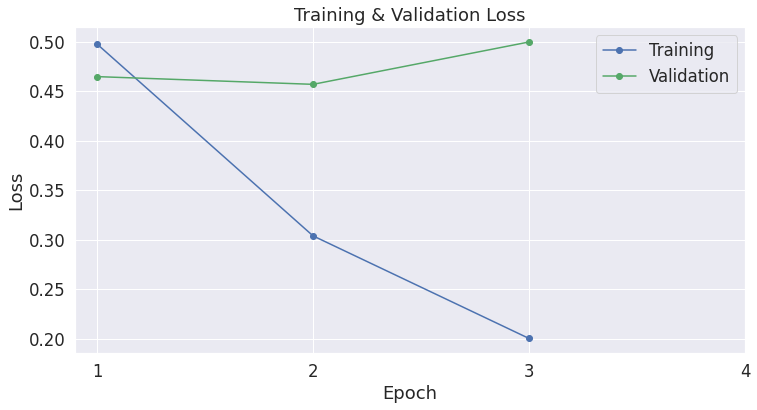

In [22]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid Loss'], 'g-o', label='Validation')

plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1,2,3,4])

plt.show()

## Test the Model

In [23]:
df = pd.read_csv(os.path.join(GDRIVE_HOME, FOLDER, 'raw/out_of_domain_dev.tsv'), delimiter='\t', header=None,
                 names=['sentence_source', 'label', 'label_notes', 'sentence'])

In [24]:
print('Number of sentences: {:,}'.format(df.shape[0]))

Number of sentences: 516


In [31]:
sentences = df['sentence'].values
labels = df['label'].values

input_ids = list()
attention_masks = list()

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(text=sent, add_special_tokens=True,
                          max_length=64, padding='max_length',
                          return_attention_mask=True, return_tensors='pt')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_tensor = torch.cat(input_ids, dim=0)
label_tensor = torch.tensor(labels)
mask_tensor = torch.cat(attention_masks, dim=0)

In [32]:
batch_size = 32

prediction_data = TensorDataset(input_tensor, mask_tensor, label_tensor)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(dataset=prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [45]:
model.eval()

predictions, truth = list(), list()

for batch in prediction_dataloader:

    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        result = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, return_dict=True)
    
    logits = result.logits

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predictions.append(logits)
    truth.append(label_ids)

## Accuracy on CoLA benchmark: "Matthews correlation coefficient(MCC)"

In [68]:
total = len(df['label'])
positive = df['label'].sum()

print('Positive samples\nTotal: {} | Positive: {}| rate: {}%'.format(total, positive, round(100*positive/total, 2)))

Positive samples
Total: 516 | Positive: 354| rate: 68.6%


In [70]:
from sklearn.metrics import matthews_corrcoef
matthews_set = list()

for i in range(len(truth)):
    pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
    matthews = matthews_corrcoef(truth[i], pred_labels_i)
    matthews_set.append(matthews)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


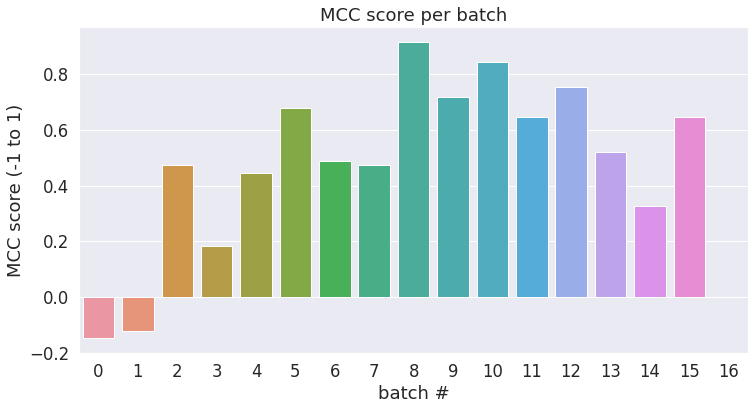

In [73]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC score per batch')
plt.ylabel('MCC score (-1 to 1)')
plt.xlabel('batch #')

plt.show()

In [78]:
# final MCC score for total dataset
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(truth, axis=0)

mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: {:.3f}'.format(mcc))

Total MCC: 0.525
